# Semantic segmentation of Colon cancer primaries

This is a demonstration of our deep learning pipeline to predict segmentation masks of colon cancer primaries in CT images.

We built our program so that it can easily be run from the command line. In this demonstration we will nevertheless import our functions and create and created an `Args()` class that can be used to specify the settings usually passed by the command line prompt. How to run our program from the command line is shown in the readme.

## Convert NIfTI to Numpy

To train our model and to predict segmentation masks we use axial 2D slices of the CT images, however the original data is provided in 3D NifTI files. We defined the `convert_to_npy()` function to convert 3D NifTI image files to 2D numpy files and save them. In this function we additionally create a JSON file that indexes every single slice. In this index we provide information of whether each slice containes tissue labled as cancer.

In the JSON file we assign each slice to the training or test subsets by calling `create_data_subsets()`. Here, the split ratio and whether to create a split based on individual slices or examples (patients) should be created. For our models we split on individual slices and ensured that the ratio between cancer and non-cancer slices is equal in test and training subset.

Both functions (`convert_to_npy()` and `create_data_subsets()`) are in `dataset.py`.


In [ ]:
from dataset import convert_to_npy, create_data_subsets

In [ ]:
class Args():
    data_path = './Task10_Colon'
    path = './data/'
    split_on = "slices"
    split = 0.1

args = Args()

convert_to_npy(args)
create_data_subsets(args)

# 2. Dataset and Data Loader

**1) Dataset**

We creates a Custom Dataset; ColonDataset. It uses JSON file which created from *create_data_subsets()* function. *ColonDataset()* class is at **data_loading.py**.  

We can set a sampling method. Otherwise, it uses the original dataset. Three sampling methods are undersample, oversample and only_tumor. Each sampling methods are defined as *get_undersample_files()*, *get_oversample_files()*, *get_only_tumor_files*, and *get_original_dataset()* at **data_loading.py**. 

When the data set is for train, it transforms the data set by resize, random crop, horizontal flipping, vertical flipping, and normalization. Otherwise, it transforms the data set by resize and normalization.

After creating ColonDataset; we split the dataset into train and valid set. This logic is implemented in the *load_datasets()* function. The load_datasets() function is at *train.py*.

**2) Data Loader**

We use *DataLoader* from **pytorch**(torch.utils.data.DataLoader). At *load_dataloader()* function, we creates two data loaders of train and valid set and put both of them in the dictionary as 'train' and 'val'. This dictionary is going to use in the training loop later.

In [1]:
from train import load_datasets, load_dataloader

In [2]:
class Args():
    split_ratio = 0.9
    train_batch = 12
    valid_batch = 12
    trainimages = "./data/npy_images"
    trainlabels = "./data/npy_labels"
    jsonfile = "./data/data_index_subsets.json"
    transform = True
    dataset_type = "only_tumor"
    image_size = 256

args = Args()

In [3]:
train, valid = load_datasets(args)
train_dataloader = load_dataloader(args, train, valid)

# 3. Visualize images from the data loader
CT images from the first batch of train_dataloader.

In [4]:
import matplotlib.pyplot as plt
from utils import gray2rgb, outline

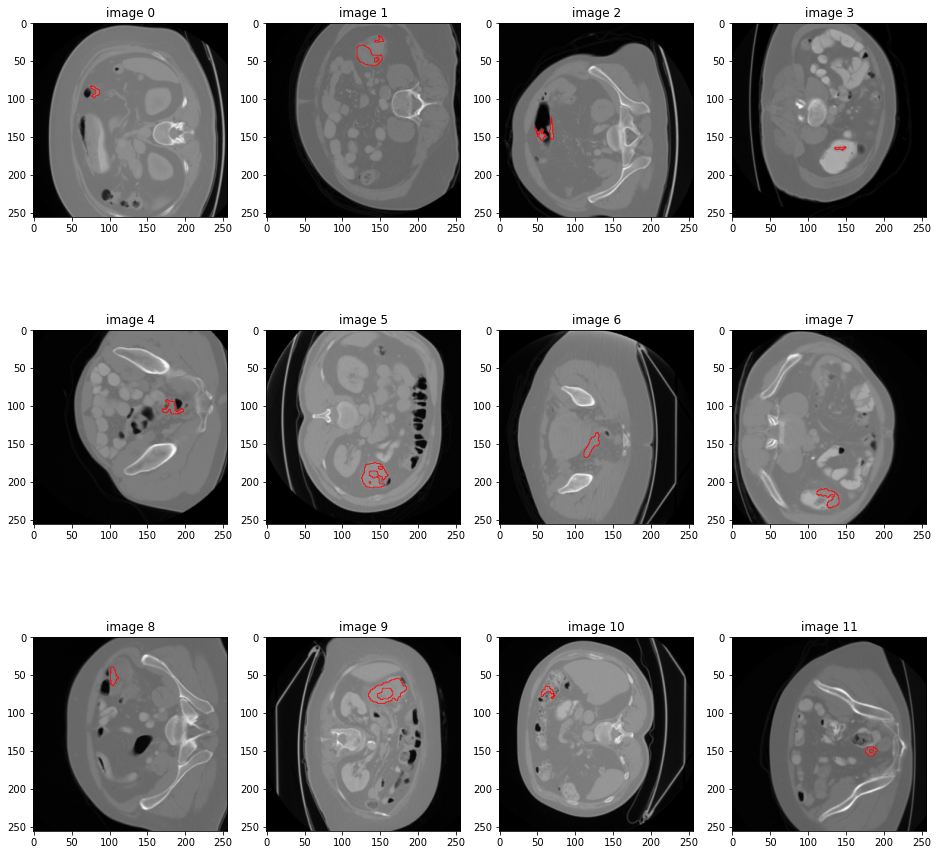

In [6]:
imgs, labels = next(iter(train_dataloader['train']))

def overlay_plot(img, y_true):
    image = gray2rgb(img[0])
    image = outline(image, y_true[0], color=[255, 0, 0])
    plt.imshow(image)

columns = 4
rows = 3
fig=plt.figure(figsize=(16, 16))
for i, (img, label) in enumerate(zip(imgs, labels)):
    fig.add_subplot(rows, columns, i+1)
    plt.title('image ' + str(i))
    overlay_plot(img, label)

# 4. U-Net Model
We use the U-Net model and the combination of ResNet with the U-Net for image segmentation task. In this demo, we use the U-Net model. Two models are implemented at **architecture.py**.

In [ ]:
from architecture import UNet

In [ ]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0") # set device to GPU if available
model = UNet(n_channel=1, n_class=1).to(device)
summary(model, input_size=(1, args.image_size, args.image_size))

RuntimeError: CUDA error: out of memory

# 5. Loss function
We use the combination of cross entrophy loss and dice loss to optimize the model. 

The cross entrophy loss is from *pytorch library*. We implements The dice coefficient at **loss.py**. The dice loss is *(1 - dice coefficient)*.

In [2]:
from loss import dice_coef, calc_loss, print_metrics

# 6. Train

We use *SGD (Stochastic gradient descent)* optimizer. The scheduler is *ReduceLROnPlateau*. It allows dynamic learning rate reducing based on some validation measurements. Both of them are from **pytorch** library. 

Early Stopping technique is also implemented at **train.py**. Early stopping is a method that allows you to specify an arbitrarily large number of training epochs and stop training once the model performance stops improving on the validation dataset.

We define *train_method()* function at **train.py**. This function receives optimizer, scheduler, and other parameters and starts training. It saves the best model which shows the lowest validation loss. 

We use Tensorbaord to visualize metrics after finishing training. We also save metrics as a JSON file to make us compare the results of each model easily.


In [ ]:
from train import train_model

In [ ]:
class Args():
    model_path = "./save/models/"
    metric_path = "./save/metrics"
    model = "unet"
    dataset_type = "only_tumor"
    lr = 0.001
    epochs = 200
    earlystop = 30
    sched_patience = 10
    
args = Args()

In [ ]:
# set device
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0") # set device to GPU if available
# specify optimizer function
optimizer = SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=args.lr, momentum=0.9)
# initialise learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', threshold_mode='abs', min_lr=1e-8, factor=0.1, patience=args.sched_patience)
# intialize the model
model = UNet(n_channel=1, n_class=1).to(device)
# initialize dictionary to save train informations about the model, dataset, and metrics at the end.
info = {'train': {}}
info_train = info['train']
info_train['model'] = args.model
info_train['dataset'] = args.dataset_type
info_train['image_size'] = args.image_size
info_train['train set size'] = len(train)
info_train['val set size'] = len(valid)
# start train
model, metric_t, metric_v = train_model(model, optimizer, scheduler, device, args.epochs, colon_dataloader, info_train)

with open(f"{args.metric_path}best_metric_{args.model}_{args.dataset_type}_{args.epochs}.json", "w") as json_file:
    json.dump(info, json_file, indent=4)

In [ ]:
# to see visualizations of loss change
!tensorboard --logdir=runs

# 7. Test
We define *load_datasets()* and *load_dataloader()* functions at **test.py** to load the test set which is splitted at the *step 1: Convert NIfTI to Numpy*. 

Similar to train_model() at the *step 7: Train*, we also define *test_model()* at **test.py** which starts evaluating the model and prints the evaluation metrics at the end. The evaluation metrics are saved at the JSON file. We create *metrics_summary()* function at **utils.py**. We can get statistics from the evaluation metrics which are saved at the JSON file.

In this demo, we are going to load the best model which is already trained using oversample sampling method with U-Net model.

In [ ]:
from test import load_datasets, load_dataloader, test_model
from utils import metrics_summary

In [ ]:
class Args():
    testimages = "./data/npy_images"
    testlabels = "./data/npy_labels"
    jsonfile = "./data/data_index_subsets.json"
    image_size = 256
    transform = True
    model_path = "./save/models/"
    metric_path = "./save/metrics"
    model = "unet"
    datset_type = "oversample"
    epochs = 200
    pred_save = True
    
args = Args()

In [ ]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0") # set device to GPU if available
model = UNet(n_channel=1, n_class=1).to(device)
test = load_datasets(args)
test_dataloader = load_dataloader(test)
# initialize a dictionary to save metrics for evaluation
info_test = {'test set size':0, 'average_dice_score':0, \
             'number of cancer case': 0, 'average_cancer_dice_score':0, \
             'number of non-cancer case': 0, 'average_non_cancer_dice_score':0, \
             'gt_c_pd_c_overlap':0, 'gt_c_pd_c_no_overlap':0, 'gt_c_pd_no_c':0, \
             'gt_n_pd_n': 0, 'gt_n_pd_c':0, 'dice_score_each_slice':[]}
info_test['test set size'] = len(colon_dataloader['test'])
# start test
result = test_model(model, device, colon_dataloader, args.pred_save, info_test)
# print out statistics
metrics_summary(args.metrics_path)

# 8. Visualize predictions from the trained model
It's not tested yet


In [7]:
import matplotlib.pyplot as plt
from utils import gray2rgb, outline, overlay_plot

In [ ]:
random_index = np.random.choice(len(result), 10)
fig=plt.figure(figsize=(16, 16))
for i in random_index:
    overlay_plot(result[i]['img'], result[i]['label'], result[i]['pred'], i, False):